In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np

## Prices 

In [2]:
url = 'https://api.energidataservice.dk/datastore_search_sql?sql=SELECT "HourUTC", "PriceArea", "SpotPriceDKK" from "elspotprices"'

In [3]:
r = requests.get(url)

In [4]:
d = r.json()

In [5]:
data = d['result']['records']

In [6]:
df = pd.DataFrame.from_dict(data)

In [7]:
DK1 = df[df.PriceArea == 'DK1']

In [8]:
DK1['HourUTC'] = DK1['HourUTC'].apply(lambda x: x.split('+')[0])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
DK1.set_index('HourUTC', inplace=True)

In [10]:
DK1.index = pd.to_datetime(DK1.index, format='%Y-%m-%dT%H:%M:%S')

In [11]:
DK1.head(24)

,PriceArea,SpotPriceDKK
HourUTC,,
2016-10-30 00:00:00,DK1,238.39
2015-03-28 01:00:00,DK1,181.74
2017-03-05 02:00:00,DK1,78.79
2017-03-24 15:00:00,DK1,225.39
2017-10-10 15:00:00,DK1,274.05
2015-12-31 23:00:00,DK1,122.29
2016-01-01 00:00:00,DK1,119.68
2016-01-01 01:00:00,DK1,117.44
2016-01-01 02:00:00,DK1,116.18


In [12]:
DK1 = DK1.resample('H').mean()

In [13]:
#DK1 = DK1[DK1.SpotPriceDKK < 2500]

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


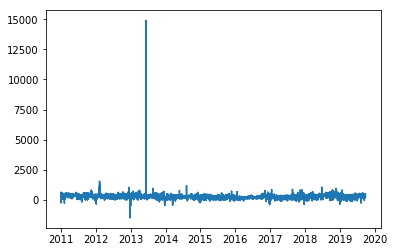

In [14]:
plt.plot(DK1.index, DK1.SpotPriceDKK)

In [15]:
DK1.describe()

,SpotPriceDKK
count,76582.000000
mean,261.155470
std,159.547858
min,-1491.920000
25%,195.150000
50%,248.910000
75%,322.630000
max,14910.800000


In [16]:
print('Fraction of values below 0: ', (DK1[DK1 < 0].count()*100 / DK1.count()).round(2))
print('Fraction of values above 300: ', (DK1[DK1 > 300].count()*100 / DK1.count()).round(2))

Fraction of values below 0:  SpotPriceDKK    0.66
dtype: float64
Fraction of values above 300:  SpotPriceDKK    31.19
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c478400>]],
      dtype=object)

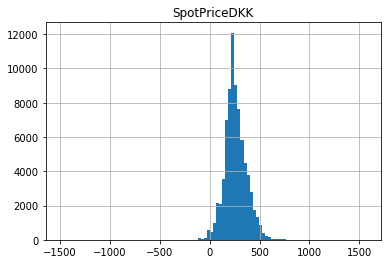

In [17]:
DK1[DK1 < 10000].hist(bins=100)

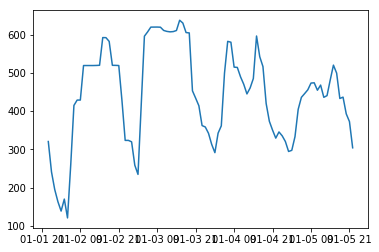

In [18]:
plt.plot(DK1.index[24:120], DK1.SpotPriceDKK[24:120])

In [19]:
def hour_data(data, hour):
    return data[data.index.hour == hour]

In [20]:
serie = pd.Series([])
for hour in range(24):
    new_serie = hour_data(DK1, hour)
    serie = pd.concat([serie, new_serie], axis=1)
    serie = serie.resample('D').sum()
    hourly = serie.drop(0, axis=1)
hourly.columns = [i for i in range(24)]

In [21]:
median = [hourly[i].median() for i in range(24)]
stdev = [hourly[i].std() for i in range(24)]
_max = [hourly[i].max() for i in range(24)]
_min = [hourly[i].min() for i in range(24)]
_95 = [np.percentile(hourly[i],95) for i in range(24)]
_05 = [np.percentile(hourly[i],5) for i in range(24)]
_99 = [np.percentile(hourly[i],99) for i in range(24)]
_01 = [np.percentile(hourly[i],1) for i in range(24)]

Text(0,0.5,'DKK/MWh')

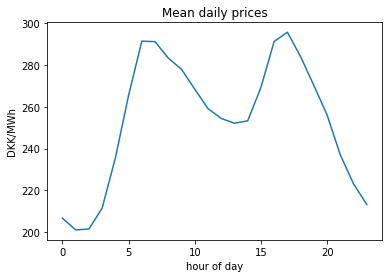

In [22]:
plt.plot(median)
plt.title('Mean daily prices')
plt.xlabel('hour of day')
plt.ylabel('DKK/MWh')

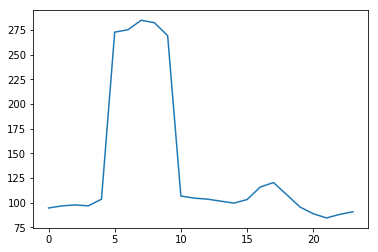

In [23]:
plt.plot(stdev)

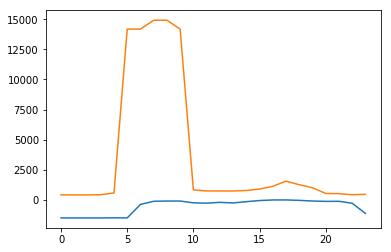

In [24]:
plt.plot(_min)
plt.plot(_max)

In [25]:
DK1.to_pickle('data/spotprice_DK1.pkl')

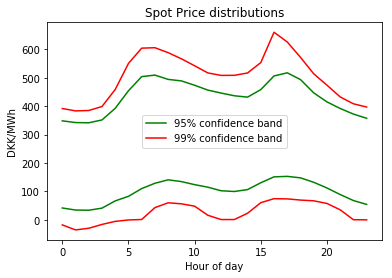

In [26]:
plt.plot(_05, color='green', label='95% confidence band')
plt.plot(_95, color='green')
plt.plot(_01, color='red', label='99% confidence band')
plt.plot(_99, color='red')
plt.title('Spot Price distributions')
plt.xlabel('Hour of day')
plt.ylabel('DKK/MWh')
plt.legend()

## Production

In [29]:
url = 'https://api.energidataservice.dk/datastore_search_sql?sql=SELECT "Minutes5UTC", "PriceArea", "ProductionLt100MW", "ProductionGe100MW", "OffshoreWindPower", "OnshoreWindPower", "SolarPower" from "electricityprodex5minrealtime"'

In [30]:
r = requests.get(url)
d = r.json()
data = d['result']['records']
df = pd.DataFrame.from_dict(data)

KeyError: 'result'

In [ ]:
df.head()

In [ ]:
DK1 = df[df.PriceArea == 'DK1']
DK2 = df[df.PriceArea == 'DK2']

In [ ]:
DK1['Minutes5UTC'] = DK1['Minutes5UTC'].apply(lambda x: x.split('+')[0])

In [ ]:
DK1.set_index('Minutes5UTC', inplace=True)

In [ ]:
DK1.index = pd.to_datetime(DK1.index, format='%Y-%m-%dT%H:%M:%S')

In [ ]:
DK1 = DK1.resample('H').sum()

In [ ]:
DK1 = DK1[DK1['ProductionLt100MW'] < 50000]

In [ ]:
plt.plot(DK1.index, DK1.ProductionGe100MW, color='red')
plt.plot(DK1.index, DK1.ProductionLt100MW, color='green')
plt.show()

In [ ]:
plt.plot(DK1.index, DK1.OnshoreWindPower, color='green')
plt.plot(DK1.index, DK1.OffshoreWindPower, color='red')
plt.plot(DK1.index, DK1.SolarPower, color='blue')
plt.show()

In [ ]:
DK1['ProductionGe100MW'].hist(bins=100)

In [ ]:
DK1['ProductionLt100MW'].hist(bins=100)

In [ ]:
DK1['Production_ratio'] = DK1['ProductionGe100MW'] / DK1['ProductionLt100MW']

In [ ]:
DK1['Production_ratio'].hist(bins=100)

In [ ]:
plt.plot(DK1['Production_ratio'])

In [ ]:
DK1['OnshoreWindPower'].hist(bins=100)

In [ ]:
DK1['OffshoreWindPower'].hist(bins=100)

In [ ]:
DK1['SolarPower'].hist(bins=100)

In [ ]:
DK1['SolarPower'][DK1.SolarPower > 25].hist(bins=100)

In [ ]:
DK1['SolarPower'][DK1.SolarPower > 100].hist(bins=100)

In [ ]:
DK1['SolarPower'][DK1.SolarPower > 1000].hist(bins=100)

In [ ]:
DK1['SolarPower'][DK1.SolarPower > 2500].hist(bins=100)